In [1]:
#!rm -rf ./saved_predictions
#!rm -rf /root/fiftyone

In [2]:
!pip install fiftyone

Atsisiunciam nuotraukas

In [3]:
import fiftyone.zoo as foz
import fiftyone as fo
import os

data_dir = "OpenImages"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

save_dir = "./saved_predictions"
os.makedirs(save_dir, exist_ok=True)

# Download train set
train_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples= 500,
    only_matching=True,
)

# Download test set
test_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="test",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples=100,
    only_matching=True,
)

val_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples=100,
    only_matching=True,
)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 500/500 [23.2s elapsed, 0s remaining, 27.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [23.2s elapsed, 0s remaining, 27.4 samples/s]      


Dataset 'open-images-v6-train-500' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-train-500' created


INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v6/test' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'test' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'test' is sufficient


Loading 'open-images-v6' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'test'


 100% |█████████████████| 100/100 [4.5s elapsed, 0s remaining, 24.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [4.5s elapsed, 0s remaining, 24.3 samples/s]      


Dataset 'open-images-v6-test-100' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-test-100' created


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


 100% |█████████████████| 100/100 [5.2s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [5.2s elapsed, 0s remaining, 19.5 samples/s]      


Dataset 'open-images-v6-validation-100' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-validation-100' created


Dataset

In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class Lab3Dataset(Dataset):
    def __init__(self, fiftyone_dataset, transforms=None):
        self.samples = list(fiftyone_dataset)  # Store samples list
        self.transforms = transforms
        self.class_to_idx = {"Strawberry": 1, "Horse": 2, "Cat": 3}  # Moved here

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load input image
        image = Image.open(sample.filepath).convert("RGB")
        W, H = image.size

        # Create empty mask (background = 0)
        mask = np.zeros((H, W), dtype=np.uint8)

        # Get detections
        detections = sample.ground_truth.detections if sample.ground_truth else []

        for det in detections:
            label = det.label
            if label not in self.class_to_idx:
                continue

            if det.mask is not None:
                # det.mask is already a numpy array
                instance_mask = np.array(det.mask, dtype=np.uint8)

                # Resize instance mask if necessary
                if instance_mask.shape != (H, W):
                    instance_mask = np.array(
                        Image.fromarray(instance_mask).resize((W, H), resample=Image.NEAREST)
                    )

                # Update full mask
                class_id = self.class_to_idx[label]
                mask[instance_mask > 0] = class_id

        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()  # Important: ensure mask is LongTensor


Transformacijos

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

test_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

Susikuriam datasetis

In [6]:
from torch.utils.data import DataLoader


train_set = Lab3Dataset(train_dataset, transforms=train_transform)
test_set = Lab3Dataset(test_dataset, transforms=test_transform)
val_set = Lab3Dataset(val_dataset, transforms=val_transform)

Pasiziurim, kas yra datasete

File: /root/fiftyone/open-images-v6/train/data/00616ae2135bc076.jpg


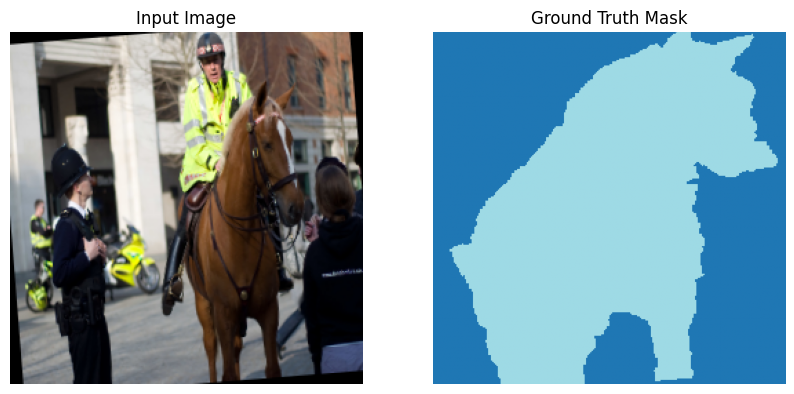

In [7]:
import matplotlib.pyplot as plt

sample_idx = 80
sample_image, sample_mask = train_set[sample_idx]

print("File:", train_set.samples[sample_idx].filepath)

if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.permute(1, 2, 0).cpu().numpy()

if isinstance(sample_mask, torch.Tensor):
    sample_mask = sample_mask.cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap="tab20")
plt.title("Ground Truth Mask")
plt.axis('off')

plt.show()

Dataloader

In [8]:
train_loader = DataLoader(train_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)
val_loader = DataLoader(val_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)

Modelis

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

Paruosiam modeli darbui

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-10-fd73dae578de>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Treniravimas

In [11]:
from pickle import TRUE
from tqdm import tqdm
import torch.optim as optium

NUM_EPOCHS = 30

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = []
    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss.append(loss.item())
        loop.set_postfix(loss=loss.item())

    model.eval()
    val_loss = []

    with torch.no_grad():
        val_loop = tqdm(val_loader)
        for val_batch_idx, (val_data, val_targets) in enumerate(val_loop):
            val_data = val_data.to(device=DEVICE)
            val_targets = val_targets.to(device=DEVICE)

            with torch.cuda.amp.autocast():
                val_predictions = model(val_data)
                loss = loss_fn(val_predictions, val_targets)

            val_loss.append(loss.item())
            val_loop.set_postfix(loss=loss.item())

    avg_train_loss = sum(train_loss) / len(train_loss)
    avg_val_loss = sum(val_loss) / len(val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-11-5fc4b92ab2d3>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-11-5fc4b92ab2d3>:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 7/7 [00:02<00:00,  3.28it/s, loss=1.6]


Epoch [1/60], Train Loss: 1.2288, Val Loss: 1.4271


100%|██████████| 7/7 [00:02<00:00,  2.74it/s, loss=1.33]


Epoch [2/60], Train Loss: 1.0883, Val Loss: 1.1390


100%|██████████| 7/7 [00:02<00:00,  2.79it/s, loss=1.42]


Epoch [3/60], Train Loss: 1.0400, Val Loss: 1.1739


100%|██████████| 7/7 [00:02<00:00,  2.97it/s, loss=1.53]


Epoch [4/60], Train Loss: 1.0110, Val Loss: 1.1939


100%|██████████| 7/7 [00:02<00:00,  3.00it/s, loss=1.29]


Epoch [5/60], Train Loss: 0.9889, Val Loss: 1.0714


100%|██████████| 7/7 [00:01<00:00,  3.59it/s, loss=1.31]


Epoch [6/60], Train Loss: 0.9537, Val Loss: 1.0326


100%|██████████| 7/7 [00:02<00:00,  2.39it/s, loss=1.33]


Epoch [7/60], Train Loss: 0.9354, Val Loss: 1.0328


100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=1.36]


Epoch [8/60], Train Loss: 0.9275, Val Loss: 1.0667


100%|██████████| 7/7 [00:01<00:00,  4.09it/s, loss=1.26]


Epoch [9/60], Train Loss: 0.9281, Val Loss: 1.0043


100%|██████████| 7/7 [00:01<00:00,  4.09it/s, loss=1.38]


Epoch [10/60], Train Loss: 0.9045, Val Loss: 1.0492


100%|██████████| 7/7 [00:02<00:00,  2.93it/s, loss=1.37]


Epoch [11/60], Train Loss: 0.8822, Val Loss: 1.0211


100%|██████████| 7/7 [00:01<00:00,  4.10it/s, loss=1.43]


Epoch [12/60], Train Loss: 0.8892, Val Loss: 1.0417


100%|██████████| 7/7 [00:01<00:00,  3.94it/s, loss=1.47]


Epoch [13/60], Train Loss: 0.8647, Val Loss: 1.0851


100%|██████████| 7/7 [00:01<00:00,  3.65it/s, loss=1.4]


Epoch [14/60], Train Loss: 0.8620, Val Loss: 1.0312


100%|██████████| 7/7 [00:02<00:00,  2.60it/s, loss=1.42]


Epoch [15/60], Train Loss: 0.8528, Val Loss: 1.0428


100%|██████████| 7/7 [00:02<00:00,  2.61it/s, loss=1.58]


Epoch [16/60], Train Loss: 0.8867, Val Loss: 1.0293


100%|██████████| 7/7 [00:02<00:00,  3.20it/s, loss=1.23]


Epoch [17/60], Train Loss: 0.8550, Val Loss: 0.9211


100%|██████████| 7/7 [00:01<00:00,  3.88it/s, loss=1.45]


Epoch [18/60], Train Loss: 0.8499, Val Loss: 1.0087


100%|██████████| 7/7 [00:01<00:00,  4.13it/s, loss=1.27]


Epoch [19/60], Train Loss: 0.8524, Val Loss: 0.9270


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=1.21]


Epoch [20/60], Train Loss: 0.8322, Val Loss: 0.9231


100%|██████████| 7/7 [00:01<00:00,  4.07it/s, loss=1.35]


Epoch [21/60], Train Loss: 0.8302, Val Loss: 1.0311


100%|██████████| 7/7 [00:01<00:00,  3.94it/s, loss=1.3]


Epoch [22/60], Train Loss: 0.8420, Val Loss: 1.0008


100%|██████████| 7/7 [00:01<00:00,  4.14it/s, loss=1.2]


Epoch [23/60], Train Loss: 0.8292, Val Loss: 0.9160


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=1.29]


Epoch [24/60], Train Loss: 0.8093, Val Loss: 0.9681


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=1.28]


Epoch [25/60], Train Loss: 0.8008, Val Loss: 0.8950


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=1.31]


Epoch [26/60], Train Loss: 0.7866, Val Loss: 0.8831


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=1.36]


Epoch [27/60], Train Loss: 0.8050, Val Loss: 0.9233


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=1.27]


Epoch [28/60], Train Loss: 0.8020, Val Loss: 0.9493


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=1.64]


Epoch [29/60], Train Loss: 0.7941, Val Loss: 0.9792


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=1.62]


Epoch [30/60], Train Loss: 0.8113, Val Loss: 0.9676


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=1.34]


Epoch [31/60], Train Loss: 0.7956, Val Loss: 0.9123


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=1.4]


Epoch [32/60], Train Loss: 0.7848, Val Loss: 0.8992


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=1.53]


Epoch [33/60], Train Loss: 0.7702, Val Loss: 0.9013


100%|██████████| 7/7 [00:01<00:00,  3.92it/s, loss=1.84]


Epoch [34/60], Train Loss: 0.8018, Val Loss: 0.9870


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=1.33]


Epoch [35/60], Train Loss: 0.7985, Val Loss: 0.9092


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=1.57]


Epoch [36/60], Train Loss: 0.7754, Val Loss: 0.9537


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=1.32]


Epoch [37/60], Train Loss: 0.7850, Val Loss: 0.9214


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=1.26]


Epoch [38/60], Train Loss: 0.7499, Val Loss: 0.8625


100%|██████████| 7/7 [00:01<00:00,  3.95it/s, loss=1.29]


Epoch [39/60], Train Loss: 0.7808, Val Loss: 0.8817


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=1.39]


Epoch [40/60], Train Loss: 0.7701, Val Loss: 0.9215


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=1.14]


Epoch [41/60], Train Loss: 0.7483, Val Loss: 0.8561


100%|██████████| 7/7 [00:01<00:00,  4.18it/s, loss=1.44]


Epoch [42/60], Train Loss: 0.7458, Val Loss: 0.9030


100%|██████████| 7/7 [00:01<00:00,  4.18it/s, loss=1.28]


Epoch [43/60], Train Loss: 0.7212, Val Loss: 0.8711


100%|██████████| 7/7 [00:01<00:00,  4.03it/s, loss=1.37]


Epoch [44/60], Train Loss: 0.7140, Val Loss: 0.9019


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=1.85]


Epoch [45/60], Train Loss: 0.7307, Val Loss: 0.9392


100%|██████████| 7/7 [00:01<00:00,  4.07it/s, loss=1.28]


Epoch [46/60], Train Loss: 0.7415, Val Loss: 0.9021


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=1.33]


Epoch [47/60], Train Loss: 0.7332, Val Loss: 0.9157


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=1.7]


Epoch [48/60], Train Loss: 0.6963, Val Loss: 0.9558


100%|██████████| 7/7 [00:01<00:00,  3.93it/s, loss=1.41]


Epoch [49/60], Train Loss: 0.7178, Val Loss: 0.8630


100%|██████████| 7/7 [00:01<00:00,  3.94it/s, loss=1.29]


Epoch [50/60], Train Loss: 0.7570, Val Loss: 0.8651


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=1.26]


Epoch [51/60], Train Loss: 0.7195, Val Loss: 0.8477


100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=1.21]


Epoch [52/60], Train Loss: 0.7193, Val Loss: 0.8302


100%|██████████| 7/7 [00:01<00:00,  3.93it/s, loss=1.27]


Epoch [53/60], Train Loss: 0.7381, Val Loss: 0.8871


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=1.93]


Epoch [54/60], Train Loss: 0.7262, Val Loss: 0.9347


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=1.07]


Epoch [55/60], Train Loss: 0.7158, Val Loss: 0.8042


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=1.68]


Epoch [56/60], Train Loss: 0.6878, Val Loss: 0.8988


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=1.1]


Epoch [57/60], Train Loss: 0.6963, Val Loss: 0.8079


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=1.56]


Epoch [58/60], Train Loss: 0.6595, Val Loss: 0.8902


100%|██████████| 7/7 [00:01<00:00,  3.94it/s, loss=1.33]


Epoch [59/60], Train Loss: 0.6864, Val Loss: 0.8660


100%|██████████| 7/7 [00:01<00:00,  4.07it/s, loss=1.34]

Epoch [60/60], Train Loss: 0.6802, Val Loss: 0.8208


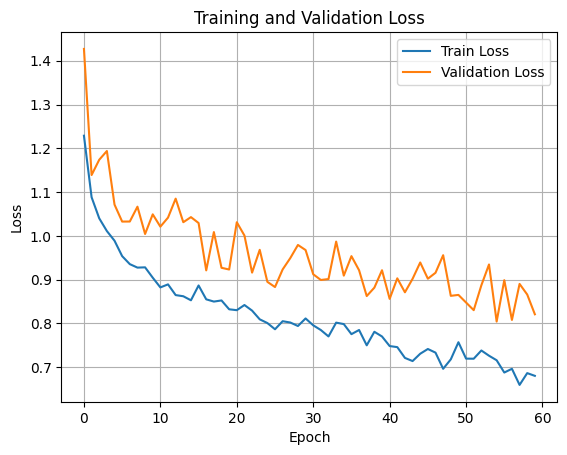

In [12]:
import matplotlib.pyplot as plt

epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [13]:
def save_predictions(loader, model, device, save_dir="./saved_predictions"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (data, targets) in enumerate(loader):
            data = data.to(device)
            targets = targets.to(device)

            preds = model(data)
            preds = torch.argmax(preds, dim=1)

            for i in range(data.shape[0]):
                pred_mask = preds[i].cpu().numpy().astype(np.uint8)
                gt_mask = targets[i].cpu().numpy().astype(np.uint8)

                pred_img = Image.fromarray(pred_mask * 80)
                gt_img = Image.fromarray(gt_mask * 80)

                pred_img.save(os.path.join(save_dir, f"pred_{idx}_{i}.png"))
                gt_img.save(os.path.join(save_dir, f"gt_{idx}_{i}.png"))

save_predictions(test_loader, model, DEVICE, save_dir="./saved_predictions")

In [16]:
!pip install torchmetrics
!pip install -U torchmetrics

  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.wh

In [18]:
import torch
import numpy as np
from torchmetrics.classification import MulticlassF1Score
import torch.nn.functional as F

def dice_score(preds, targets, num_classes, epsilon=1e-6):
    dices = []
    preds = preds.flatten()
    targets = targets.flatten()

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls

        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()

        dice = (2. * intersection + epsilon) / (total + epsilon)
        dices.append(dice.item())

    return dices

# Setup
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IGNORE_INDEX = 0

class_names = ["Background", "Strawberry", "Horse", "Cat"]

f1_micro = MulticlassF1Score(num_classes=NUM_CLASSES, average="micro", ignore_index=IGNORE_INDEX).to(DEVICE)
f1_macro = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro", ignore_index=IGNORE_INDEX).to(DEVICE)
f1_per_class = MulticlassF1Score(num_classes=NUM_CLASSES, average=None, ignore_index=IGNORE_INDEX).to(DEVICE)

model.eval()
dice_scores_all = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(data)
        preds = torch.argmax(preds, dim=1)

        f1_micro.update(preds, targets)
        f1_macro.update(preds, targets)
        f1_per_class.update(preds, targets)

        batch_dices = dice_score(preds, targets, num_classes=NUM_CLASSES)
        dice_scores_all.append(batch_dices)

# Compute final metrics
micro_f1 = f1_micro.compute().item()
macro_f1 = f1_macro.compute().item()
f1_per_class_values = f1_per_class.compute()
dice_per_class_values = np.mean(dice_scores_all, axis=0)

# Print overall
print(f"\nOverall Results:")
print(f"Micro-F1 Score: {micro_f1:.4f}")
print(f"Macro-F1 Score: {macro_f1:.4f}")

macro_dice = np.mean(dice_per_class_values[1:])
print(f"Dice Score: {macro_dice:.4f}\n")

# Print per-class
for i, class_name in enumerate(class_names):
    if i == IGNORE_INDEX:
        continue  # skip background
    print(f"{class_name} - F1 Score: {f1_per_class_values[i].item():.4f}, Dice Score: {dice_per_class_values[i]:.4f}")



Overall Results:
Micro-F1 Score: 0.6968
Macro-F1 Score: 0.5003
Macro Dice Score (no background): 0.5198

Strawberry - F1 Score: 0.4123, Dice Score: 0.2179
Horse - F1 Score: 0.7605, Dice Score: 0.5915
Cat - F1 Score: 0.8284, Dice Score: 0.7499
